# Tidal regression

**What does this notebook do?** 

This notebook uses the ([OSU Tidal Prediction Software or OTPS](http://volkov.oce.orst.edu/tides/otps.html)) to tidally tag a time series of Landsat imagery, and then compute pixel-wise regression based on NDWI values.

**Requirements:** 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

`module load otps`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** August 2018

**Authors:** Robbi Bishop-Taylor, Bex Dunn

## Import modules

In [21]:
import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
from otps import TimePoint
from otps import predict_tide
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling

%load_ext autoreload
%autoreload 2

# Create datacube instance
dc = datacube.Datacube(app='Tidal regression')


## Import remotely-sensed time series data
Imports a time series of Landsat observations as a DEA `xarray` dataset.

Loading ls5 PQ
    Loading 134 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 52 filtered ls7 timesteps
Loading ls8 PQ
    Loading 58 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


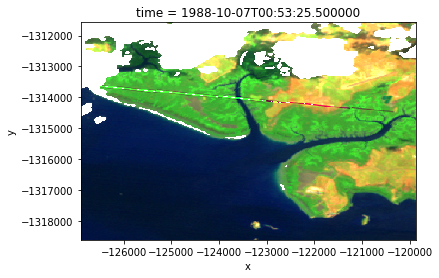

In [46]:
# Set up analysis data query using 
lat, lon, buffer = -12.463, 130.885, 3500
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),         
         'crs': 'EPSG:3577',
         'time': ('1987-01-01', '2018-06-30')}

# Mask used to identify bad pixels
mask_dict = {'cloud_acca': 'no_cloud', 
             'cloud_fmask': 'no_cloud', 
             'cloud_shadow_acca':'no_cloud_shadow',
             'cloud_shadow_fmask':'no_cloud_shadow',
             'blue_saturated':False,
             'green_saturated':False,
             'red_saturated':False,
             'nir_saturated':False,
             'swir1_saturated':False,
             'swir2_saturated':False,
             'contiguous': True}

# Import data
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5', 'ls7', 'ls8'],
                                         bands_of_interest=['swir1', 'nir', 'green'],
                                         mask_dict=mask_dict, masked_prop=0.8, apply_mask=True)

# Plot data
data[['swir1', 'nir', 'green']].isel(time=6).to_array().plot.imshow(robust=True)


## Tidal modelling using OTPS
and extracts a list of timestamps based on the time and date of acquisition for each Landsat observation. These timestamps can then be used as one of the inputs to the [OSU Tidal Prediction Software (OTPS) tidal model](http://volkov.oce.orst.edu/tides/otps.html) to compute tidal heights at the time of acquisition of each Landsat observation.

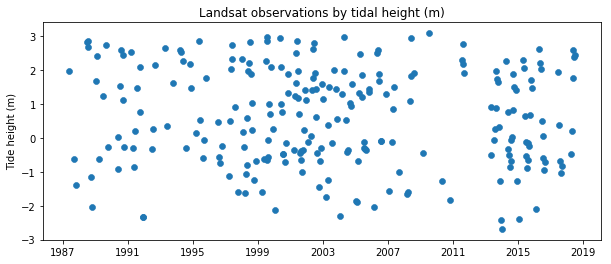

In [47]:
# Extract list of datetimes based on Landsat time of acquisition for each image
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()

#Set a tide post: this is the location the OTPS model uses to compute tides for the supplied datetimes
tidepost_lat, tidepost_lon = -12.48315, 130.85540

# The OTPS model requires inputs as 'TimePoint' objects, which are combinations of lon-lat coordinates 
# and a datetime object. You can create a list of these with a list comprehension:
observed_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in observed_datetimes]

# Feed the entire list of timepoints to the OTPS `predict_tide` function:
observed_predictedtides = predict_tide(observed_timepoints)

# For each of the predicted tide objects, extract a list of tidal heights in `m` units relative to mean 
# sea level (the `tide_m` method should not be confused with the `depth_m` method, which gives you the 
# ocean depth at the tide post location that is used by the OTPS model to predict tides)
observed_tideheights = [predictedtide.tide_m for predictedtide in observed_predictedtides]

# Create a dataframe of tidal heights for each Landsat observation
observed_df = pd.DataFrame({'tide_height': observed_tideheights}, 
                           index=pd.DatetimeIndex(observed_datetimes))

# Plot tidal heights against Landsat observation date
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(observed_df.index, observed_df.tide_height, linewidth=0.6, zorder=1, label='Modelled')
ax.set_title('Landsat observations by tidal height (m)')
ax.set_ylabel('Tide height (m)');


### Tagging, filtering and compositing Landsat observations by tidal height/stage
Adds tidal height data back into our original `xarray` dataset so that each Landsat observation is correctly tagged with its corresponding tidal height. Tagged images can then be filtered or composited to study characteristics of the coastline at various tidal stages.

In [48]:
data['tide_heights'] = xr.DataArray(observed_tideheights, [('time', data.time)])

## Compute MNDWI for all timesteps

In [51]:
data['mndwi'] = (data.green - data.swir1) / (data.green + data.swir1)
data
# mndwi.plot(col='time', col_wrap=6, robust=True)

<xarray.Dataset>
Dimensions:       (time: 244, x: 281, y: 281)
Coordinates:
  * y             (y) float64 -1.312e+06 -1.312e+06 -1.312e+06 -1.312e+06 ...
  * x             (x) float64 -1.269e+05 -1.269e+05 -1.268e+05 -1.268e+05 ...
  * time          (time) datetime64[ns] 1987-05-30T00:47:23 ...
Data variables:
    swir1         (time, y, x) float64 2.985e+03 3.072e+03 2.75e+03 ...
    nir           (time, y, x) float64 2.429e+03 2.384e+03 2.448e+03 ...
    green         (time, y, x) float64 1.635e+03 1.503e+03 1.186e+03 ...
    data_perc     (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    tide_heights  (time) float64 1.986 -0.626 -1.399 2.836 2.682 2.854 ...
    mndwi         (time, y, x) float64 -0.2922 -0.343 -0.3974 -0.3869 ...
Attributes:
    crs:      EPSG:3577